# Tree Cutting Prioraty

For show the result in QGIS 

1. Click on (Run All) to run the code
2. Open QGIS
3. Go to Layer → Add Layer → Add Vector Layer
4. Browse to your file:
5. cutting_priority.shp
6. Click Add
7. Right-click the layer → Properties
8. Go to Symbology
9. Change Render type to Graduated
10. Column = priority
11. Choose a color scheme: YlOrRd, RdYlGn, or Spectral
12. Click Classify
13. Press Apply

## Import Libraries

These are all the Python libraries required for the GIS workflow.

In [18]:
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from rasterstats import zonal_stats
from rasterio.features import rasterize
from rasterio.transform import from_origin
from scipy.ndimage import distance_transform_edt

DATA_DIR = "data"
TARGET_CRS = "EPSG:3857"
CELL_SIZE = 30  


## Load All Shapefiles

Load the data you have already stored in your data/ directory.

In [19]:
layer_files = {
    "trees": "SBNFMortalityt.shp",
    "community": "Communityfeatures.shp",
    "roads": "EgressRoutes.shp",
    "population": "PopulatedAreast.shp",
    "dist_circuits": "DistCircuits.shp",
    "transmission": "Transmission.shp",
    "substations": "Substations.shp",
    "grid": "CuttingGrids.shp",
    "town_boundary": "TownBoundary.shp",
}

layers = {}
for name, fname in layer_files.items():
    fpath = os.path.join(DATA_DIR, fname)
    gdf = gpd.read_file(fpath)
    layers[name] = gdf.to_crs(TARGET_CRS)

trees        = layers["trees"]
community    = layers["community"]
roads        = layers["roads"]
population   = layers["population"]
transmission = layers["transmission"]
substations  = layers["substations"]
grid         = layers["grid"]
town_boundary = layers["town_boundary"]


## Create a Base Raster Grid

We prepare a raster canvas based on the town boundary.

In [20]:
minx, miny, maxx, maxy = town_boundary.total_bounds

width  = int((maxx - minx) / CELL_SIZE)
height = int((maxy - miny) / CELL_SIZE)

transform = from_origin(minx, maxy, CELL_SIZE, CELL_SIZE)


## Define Feature-to-Raster Function

This converts polygons/lines into binary rasters.

In [22]:
def vector_to_raster(gdf, height, width, transform, burn_value=1, nodata=0, dtype="int16"):
    
    shapes = [(geom, burn_value) for geom in gdf.geometry]
    return rasterize(
        shapes,
        out_shape=(height, width),
        transform=transform,
        fill=nodata,
        dtype=dtype,
    )

## Rasterize All Input Feature Layers

This produces one raster mask for each criterion.

In [23]:
trees_r = vector_to_raster(trees, height, width, transform)
comm_r  = vector_to_raster(community, height, width, transform)
roads_r = vector_to_raster(roads, height, width, transform)
pop_r   = vector_to_raster(population, height, width, transform)

trans_r = vector_to_raster(transmission, height, width, transform)
subs_r  = vector_to_raster(substations, height, width, transform)
util_r  = ((trans_r > 0) | (subs_r > 0)).astype("int16")

## Compute Euclidean Distances for Each Raster

Euclidean distance is measured from every cell to the nearest feature.

In [24]:
def euclidean_distance(mask, cell_size):
    dist_pixels = distance_transform_edt(mask == 0)
    return dist_pixels * cell_size


dist_trees = euclidean_distance(trees_r, CELL_SIZE)
dist_comm  = euclidean_distance(comm_r, CELL_SIZE)
dist_roads = euclidean_distance(roads_r, CELL_SIZE)
dist_pop   = euclidean_distance(pop_r, CELL_SIZE)
dist_util  = euclidean_distance(util_r, CELL_SIZE)


## Reclassify Distance Rasters

We convert distance values into categories (1–5) for weighted overlay.

In [25]:
def classify_distance(dist_grid):
 
    classes = np.zeros_like(dist_grid, dtype=np.int16)
    classes[dist_grid <= 100] = 5
    classes[(dist_grid > 100) & (dist_grid <= 300)] = 4
    classes[(dist_grid > 300) & (dist_grid <= 600)] = 3
    classes[(dist_grid > 600) & (dist_grid <= 1000)] = 2
    classes[dist_grid > 1000] = 1
    return classes


rc_trees = classify_distance(dist_trees)
rc_comm  = classify_distance(dist_comm)
rc_roads = classify_distance(dist_roads)
rc_pop   = classify_distance(dist_pop)
rc_util  = classify_distance(dist_util)


## Weighted Overlay to Compute Priority

Multiply each reclassified raster by its factor weight and sum.

In [26]:
weights = {
    "trees": 10,
    "community": 15,
    "roads": 15,
    "population": 25,
    "utilities": 5,
}

layer_scores = {
    "trees": rc_trees,
    "community": rc_comm,
    "roads": rc_roads,
    "population": rc_pop,
    "utilities": rc_util,
}

priority_raster = np.zeros_like(rc_trees, dtype=np.float32)
for name, arr in layer_scores.items():
    w = weights.get(name, 0)
    priority_raster += arr * w


## Zonal Statistics to Assign Priority to Each Grid Cell

We compute the mean priority per polygon in CuttingGrid.

In [27]:
zs = zonal_stats(
    grid,
    priority_raster,
    affine=transform,
    stats=["mean"],
    nodata=0,
)

grid["priority"] = [row["mean"] for row in zs]


## Visualize Priority Per Area

We make a map of the final tree-cutting priority.

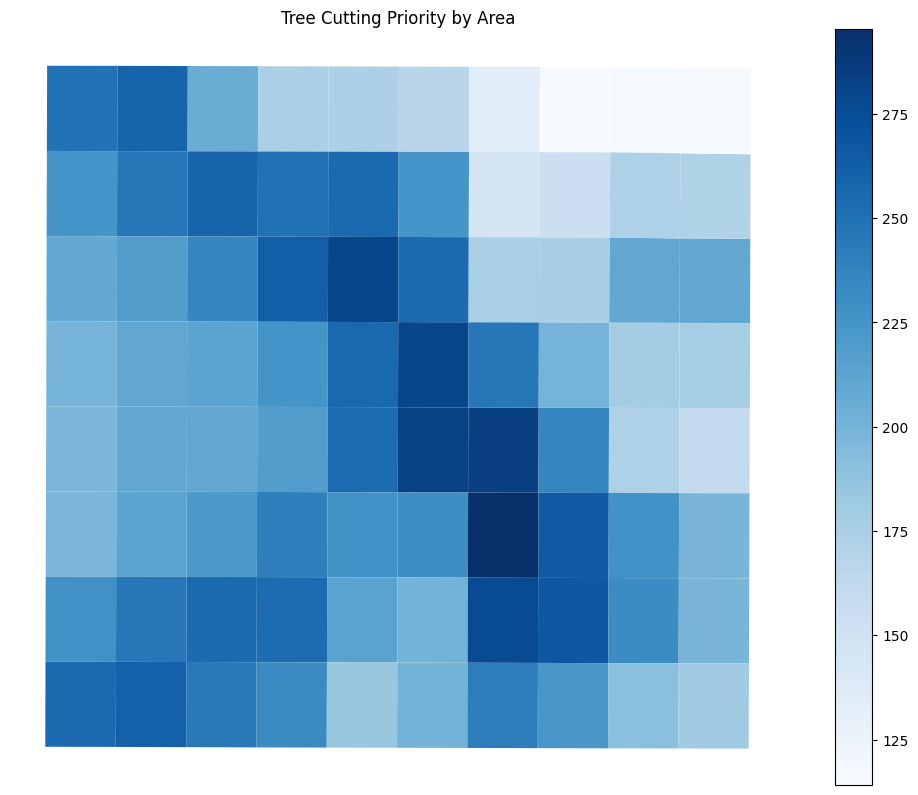

In [28]:
ax = grid.plot(
    column="priority",
    cmap="Blues",
    legend=True,
    figsize=(10, 8),
    edgecolor="none",
)

ax.set_axis_off()
plt.title("Tree Cutting Priority by Area", fontsize=12)
plt.tight_layout()
plt.savefig("tp.png", dpi=300, bbox_inches="tight")
plt.show()


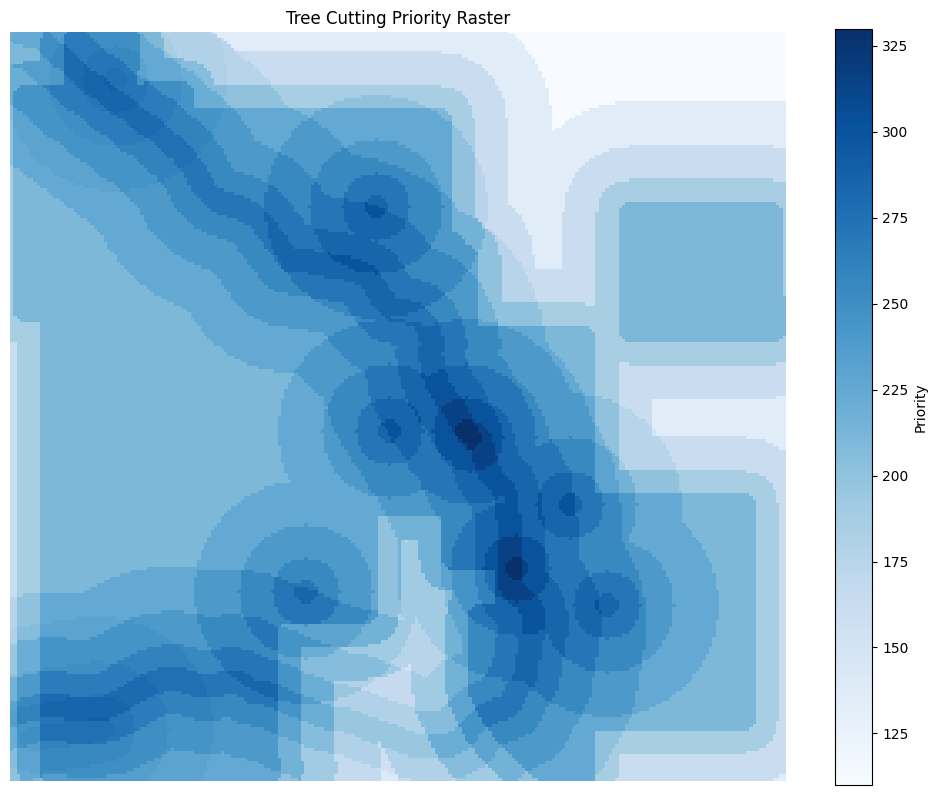

In [30]:
plt.figure(figsize=(10, 8))
plt.imshow(priority_raster, cmap="Blues")
plt.colorbar(label="Priority")
plt.title("Tree Cutting Priority Raster")
plt.axis("off")
plt.tight_layout()
plt.show()

## Save Result for QGIS

Export final shapefile with priority values.

In [31]:
os.makedirs(name="results", exist_ok=True)

grid.to_file("results/cutting_priority.shp")